In [33]:
import numpy as np

# Global constants
g = 9.81  # m/s^2
density_water = 1000  # kg/m^3
atmospheric_pressure = 101325  # Pa


def calculate_buoyancy(density_fluid, v):
    """
    Calculates the buoyant force acting oon an object

    density_fluid: density of a fluid in kg/m^3
    v: volume of an object in m^3
    """
    if density_fluid <= 0 or v <= 0:
        raise ValueError("Density and volume must be positive quantities")
    return density_fluid * v * g  # N


def will_it_float(V, mass):
    """
    Determines if an object will float in water

    V: volume of an oject in m^3
    mass: mass of an object in kg
    """
    if mass <= 0 or V <= 0:
        raise ValueError("Mass and volume must be positive quantities")
    return (mass / V) < density_water


def calculate_pressure(depth):
    """
    Determines the pressure at a given depth

    depth: current depth of the water in m(positive and negative inputs are valid)
    """

    return atmospheric_pressure + density_water * abs(depth) * g  # N / m^2


def calculate_acceleration(F, m):
    """
    Calculates linear acceleration given the force applied and the mass of an object

    F: force applied in N
    m: mass of the object in kg
    """

    if m <= 0:
        raise ValueError("The object must have a positive mass")
    return F / m  # m/s^2


def calculate_angular_acceleration(tau, I):
    """
    Calculates angular accelration given the torque applied and the moment of inertia of an object

    tau: torque applied in N*m
    I: moment of inertia of the object in kg*m^2
    """

    if I <= 0:
        raise ValueError("The object must have a positive moment of inertia")
    return tau / I  # m/s^2


def calculate_torque(F_magnitude, F_direction, r):
    """
    Calculate the torque given the magnitude of force applied on an object, its direction, and the distance from the axis of rotation

    F_magnitude: magnitude of the force applied in N, with a positive or negative sign denoting the direction of the force
    F_direction: direction of the force applied in degrees relative to the axis of rotation
    r: distance from the axis of rotation to where the force is applied in m
    """

    if r <= 0:
        raise ValueError("Distance must be a positive quantity")
    return r * F_magnitude * np.sin(np.deg2rad(F_direction))  # N*m


def calculate_moment_of_inertia(m, r):
    """
    Calculate the moment of inertai of an object given its mass and distance from the axis of rotation to its center of mass

    m: mass of the object in kg
    r: distance from the axis of rotation to the object's center of mass in m
    """

    if m <= 0 or r < 0:
        raise ValueError(
            "Object must have a positive mass, and the distance from the axis of rotation to the center of mass of the object must be positive"
        )
    return m * r**2  # kg*m^2


def calculate_auv_acceleration(
    F_magnitude, F_angle, mass=100, volume=0.1, thruster_distance=0.5
):
    """
    Calculates the directional accelerations of an AUV, returned in a numpy array,  given the magnitude and direction of the force exerted by the thruster, the mass and volume of the AUV, and the distance from the thruster to the center of mass of the AUV

    F_magnitude: magnitude of force applied by the thruster in N
    F_angle: angle of the thruster in rad, measured from the x-axis, with positive angles measured in the counter-clockwise direction
    mass(optional): mass of the AUV in kg; default value is 100 kg
    volume(optional): volume of the AUV in m^3; default values is 0.1 m^3
    thruster_distance(optional): distance from the center of mass of the AUV to the thrusters; default value is 0.5 m
    """

    if (
        (abs(F_angle) > np.pi / 6 or thruster_distance < 0)
        or (volume <= 0 or mass <= 0)
        or abs(F_magnitude) > 100.0
    ):
        raise ValueError(
            "Thrusters are unable to rotate beyond thirty degrees in either direction, thruster distance must be a positive quantity, volume and mass must be quantity, and thruster may only apply forces with a magnitude of less than 100 m"
        )
    return np.array(
        [
            calculate_acceleration(F_magnitude * np.cos(F_angle), mass),
            calculate_acceleration(F_magnitude * np.sin(F_angle), mass),
        ]
    )


def calculate_auv_angular_acceleration(
    F_magnitude, F_angle, inertia=1, thruster_distance=0.5
):
    """
    Calculates the angular acceleration of an AUV given the magnitude and direction of the force applied, the inertia of the ROV, and the distance to the thruster from teh AUV's center of mass

    F_magnitude: magnitude of force applied by the thruster in N
    F_angle: angle of the thruster in rad, measured from the x-axis, with positive angles measured in the counter-clockwise direction
    inertia: moment of inertia of the object in kg*m^2
    thruster_distance(optional): distance from the center of mass of the AUV to the thrusters; default value is 0.5 m

    """

    if (thruster_distance < 0 or abs(F_angle) > np.pi / 6) or inertia <= 0:
        raise ValueError(
            "Thruster distance cannot be negative, the thruster may not rotate more than thirty degrees in either directions, and the moment of inertia of the AUV must be positive"
        )
    return calculate_angular_acceleration(
        calculate_torque(F_magnitude, np.rad2deg(F_angle), thruster_distance), inertia
    )


# More testing necessary
def calculate_auv2_acceleration(T, alpha, theta, mass=100):
    """
    Calculates the acceleration of the AUV in the 2-D plane given the forces applied by each of the four thrusters, the angle at which the thrusters are rotated, the angle at which the AUV is rotated, and the mass of the AUV

    T:  np.ndarray of the magnitude of forces applied by each of the four the thrusters in N
    alpha: angle of the thruster in rad
    theta: angle at which the AUV is rotated in rad relative to the global context
    mass(optional): mass of the AUV in kg , the default value is 100 kg
    """

    if type(T) != np.ndarray:
        raise TypeError("Input array must be a numpy array")
    if mass <= 0 or (T.shape[0] != 4 and T.ndim >= 1):
        raise ValueError(
            "The mass of the object must be a positive quantity, and the forces array must be a numpy array and have an entry for each thruster"
        )
    r_alpha = np.array(
        [
            [np.cos(alpha), np.cos(alpha), -np.cos(alpha), -np.cos(alpha)],
            [np.sin(alpha), -np.sin(alpha), -np.sin(alpha), np.sin(alpha)],
        ]
    )
    r_theta = np.array(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    )
    return np.dot(r_theta, np.dot(r_alpha, T)) / mass


def calculate_auv2_angular_acceleration(T, alpha, L, l, inertia=100):
    """
    Calculate the angular acceleration of the AUV given the forces applied by each of the four thrusters, the angle at which the thrusters are rotated, the angle at which the AUV is rotated, the dimensions of the AUV, and the rotational inertia of the AUV

    T:  np.ndarray of the magnitude of forces applied by each of the four the thrusters in N
    alpha: angle of the thruster in rad
    theta: angle at which the AUV is rotated in rad relative to the global context
    L: distance from the center of mass of the AUV to the thrusters on the major axis of the AUV in m
    l: distance from the center of mass of the AUV to the thrusters on the minor axis of the AUV in m
    inertia(optional): rotational inertia of the AUV, measured in kg*m^2
    """
    if type(T) != np.ndarray:
        raise TypeError("Input array must be a numpy array")
    if (l < 0 or L < 0) or (T.shape[0] != 4 and T.ndim >= 1) or inertia <= 0:
        raise ValueError(
            "Dimensions of the AUV cannot be negative quantities, the forces array must be a numpy array and have four entries, and the inertia must be a positive quantitiy"
        )
    r_rotation = np.array([1, -1, 1, -1])
    sin_gamma = L * np.sin(alpha) + l * np.cos(alpha)
    return np.dot(r_rotation.T, T) * sin_gamma / inertia


def simulate_auv2_motion(
    T, alpha, L, l, inertia=100, mass=100, dt=0.1, t_final=10, x0=0, y0=0, theta0=0
):
    """
    Simulates the motion of the AUV in the 2-D plane, assume it starts at the origin with an initial velocity of 0 m/s, with the ability to move and rotate in any direction simultaneously

    T: np.ndarray of the magnitude of forces applied to the thrusters in rad
    alpha: angle of the thruster relative to the x-axis in rad
    L: distance from the center of mass of the AUV to the thrusters on the major axis of the AUV in m
    l: distance from the center of mass of the AUV to the thrusters on the minor axis of the AUV in m
    inertia(optional): rotational inertia of the AUV, measured in kg*m^2
    dt(optional): time step of the simulation in s
    t_final(optional): final time of the simulation in s
    x0(optional): initial x-position of the AUV in m
    y0(optional): initial y-position of the AUV
    theta0(optional): the initial angle of the AUV in rad
    """
    t = np.arange(0, t_final, dt)
    x = np.zeros_like(t)
    y = np.zeros_like(t)
    theta = np.zeros_like(t)
    v = np.zeros((int(t_final / dt) + 1, 2))
    omega = np.zeros_like(t)
    a = np.zeros((int(t_final / dt) + 1, 2))

    x[0] = x0
    y[0] = y0
    theta[0] = theta0
    a_angular = calculate_auv2_angular_acceleration(T, alpha, L, l, inertia)
    a[0] = calculate_auv2_acceleration(T, alpha, theta0)

    for i in range(1, len(t)):
        omega[i] = omega[i - 1] + a_angular * dt
        a[i][:] = calculate_auv2_acceleration(T, alpha, theta[i - 1])
        v[i][:] = v[i - 1] + a[i - 1] * dt
        x[i] = x[i - 1] + v[i - 1][0] * dt
        y[i] = y[i - 1] + v[i - 1][1] * dt
        theta[i] = theta[i - 1] + omega[i - 1] * dt

    return (t, x, y, theta, v, omega, a)


# Test 9 Debugging

print(calculate_auv2_acceleration(np.array([1.0, 3.0, 1.0, 2.0]), 0.5, 0.3))
print(
    calculate_auv2_angular_acceleration(np.array([1.0, 3.0, 1.0, 2.0]), 0.5, 1.5, 1.8)
)

"""
Expected Output:
[ 0.00980067 -0.00198669]
-0.06896360757926927
"""

[ 0.00980067 -0.00198669]
-0.06896360757926927


'\nExpected Output:\n[ 0.00980067 -0.00198669]\n-0.06896360757926927\n'

[ 0.          0.         -0.004      -0.012      -0.024      -0.03999959
 -0.05999544 -0.0839764  -0.11191599 -0.14376274 -0.17942818 -0.21877319
 -0.26159321 -0.30760323 -0.35642415 -0.40757215 -0.46045352 -0.51436745
 -0.56851965 -0.62204928 -0.67407089 -0.72373197 -0.77028403 -0.81316293
 -0.85207022 -0.88704433 -0.91850745 -0.94727308 -0.9745006  -1.00158859
 -1.03000792 -1.06108848 -1.09578819 -1.13448689 -1.17685529 -1.22184737
 -1.26784782 -1.31297496 -1.35549646 -1.39427104 -1.42909703 -1.46084572
 -1.49129492 -1.52265768 -1.55690686 -1.59509522 -1.63691964 -1.68073869
 -1.72411379 -1.76473649 -1.80140403 -1.8346134  -1.86643838 -1.89964176
 -1.93635669 -1.97696201 -2.01978531 -2.06191203 -2.10077993 -2.13570755
 -2.16840365 -2.20200596 -2.2391041  -2.27997107 -2.32226815 -2.36260446
 -2.39899586 -2.43243488 -2.46623686 -2.50346052 -2.54435986 -2.58605801
 -2.6249498  -2.65992125 -2.69347074 -2.72946768 -2.76943398 -2.81094429
 -2.8499746  -2.88506767 -2.91898013 -2.95578584 -2

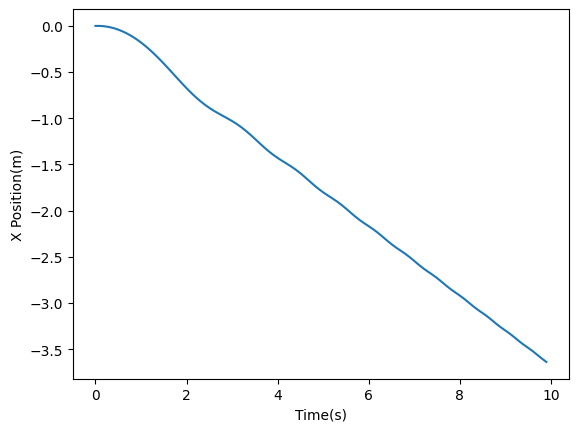

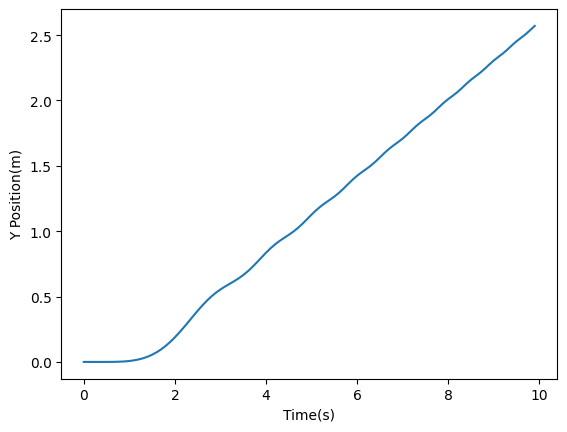

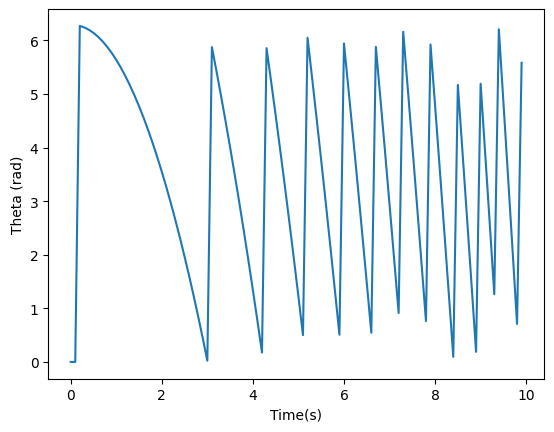

In [35]:
import numpy as np
import matplotlib.pyplot as plt

t, x, y, theta, v, omega, a = simulate_auv2_motion(
    np.array([40.0, 60.0, 80.0, 100.0]), np.pi / 3, 3.0, 2.0
)


def plot_auv2_motion_2d(t, x, y, theta):
    plt.plot(t, x, label="x")
    plt.xlabel("Time(s)")
    plt.ylabel("X Position(m)")
    plt.show()

    plt.plot(t, y, label="y")
    plt.xlabel("Time(s)")
    plt.ylabel("Y Position(m)")
    plt.show()

    plt.plot(t, np.mod(theta, (2 * np.pi)), label="theta")
    plt.xlabel("Time(s)")
    plt.ylabel("Theta (rad)")
    plt.show()


def plot_auv2_motion_3d(t, x, y, theta):
    ax = plt.axes(projection="3d")
    ax.plot3D(t, x, y)

    plt.show()


print(x)
print(y)
plot_auv2_motion_2d(t, x, y, theta)